# Inspecting synthetic galaxy catalogs

The purpose of this notebook is to run create a large sample of synthetic cluster members.  Later on these synthetic cluster members will be used to populate synthetic galaxy clusters


## Objectives




## Setup

This notebook relies on two prerequisites:

    * Data files from the previous calculation step. That is the output of the rejection sampling
    * synthetic software package. The host package of this tutorial


## Output

The outuput of this claculation is a very large set of synthetic galaxies sampled from the
    
    * galaxy clusters member model
    * reference line of sight model
    
## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [2]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp


import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle
import glob
import healpy as hp
import images
import NFW

import astropy.cosmology as cosmology

import multiprocessing as mp

import galsim
import meds

import synthetic.tools as tools
import synthetic.emulator.emulator as emulator
import synthetic.emulator.indexer as indexer
import synthetic.emulator.reader as reader
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.mcal as mcal


In [3]:
folder_path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/"

In [4]:
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/"

In [5]:
fnames = glob.glob(in_path + "*pixel*h5")
pixels = np.array([int(tmp.split("-")[-1].split(".")[0]) for tmp in fnames])
pixel_id = 0

alltable = pd.read_hdf(fnames[pixel_id], key='data')
ra_cen = np.mean(alltable["ra"])
dec_cen = np.mean(alltable["dec"])

pad = 0.17 # degree
mag_max = 25

ii = (np.abs(alltable["ra"] - ra_cen) < pad) & (np.abs(alltable["dec"] - dec_cen) < pad) & (alltable['mag_i'] < mag_max)
table = alltable[ii]
ra = (table["ra"] - ra_cen) * 60. 
dec = (table["dec"] - dec_cen) * 60.

In [6]:
pixel_scale = 0.264
mock_catalog = pd.DataFrame()
mock_catalog["RA"] = table["ra"]
mock_catalog["DEC"] = table["dec"]
mock_catalog["X"] = (table["ra"] - ra_cen) * 60 * 60 / pixel_scale + 2499.5
mock_catalog["Y"] = (table["dec"] - dec_cen) * 60 * 60 / pixel_scale + 2499.5

mock_catalog["MAG_I"] = table["mag_i"]
mock_catalog["TSIZE"] = table["size_true"]
mock_catalog["FRACDEV"] = 0
mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
mock_catalog["G1"] = table["ellipticity_1_true"]
mock_catalog["G2"] = table["ellipticity_2_true"]

In [7]:
def make_mock(table, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    pixel_scale = 0.264
    mock_catalog = pd.DataFrame()
    mock_catalog["RA"] = table["ra"]
    mock_catalog["DEC"] = table["dec"]
    mock_catalog["X"] = (table["ra"] - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    mock_catalog["Y"] = (table["dec"] - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]

    mock_catalog["MAG_G"] = table["mag_g"]
    mock_catalog["FLUX_G"] = tools.toflux(table["mag_g"])
    mock_catalog["MAG_R"] = table["mag_i"]
    mock_catalog["FLUX_R"] = tools.toflux(table["mag_r"])
    mock_catalog["MAG_I"] = table["mag_i"]
    mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
    mock_catalog["MAG_Z"] = table["mag_z"]
    mock_catalog["FLUX_Z"] = tools.toflux(table["mag_z"])

    mock_catalog["TSIZE"] = table["size_true"]
    mock_catalog["FRACDEV"] = 0
    mock_catalog["G1"] = table["ellipticity_1_true"]
    mock_catalog["G2"] = table["ellipticity_2_true"]    
    return mock_catalog

def radec2xy(ra, dec, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    x = (ra - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    y = (dec - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]
    return x.values, y.values

In [8]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

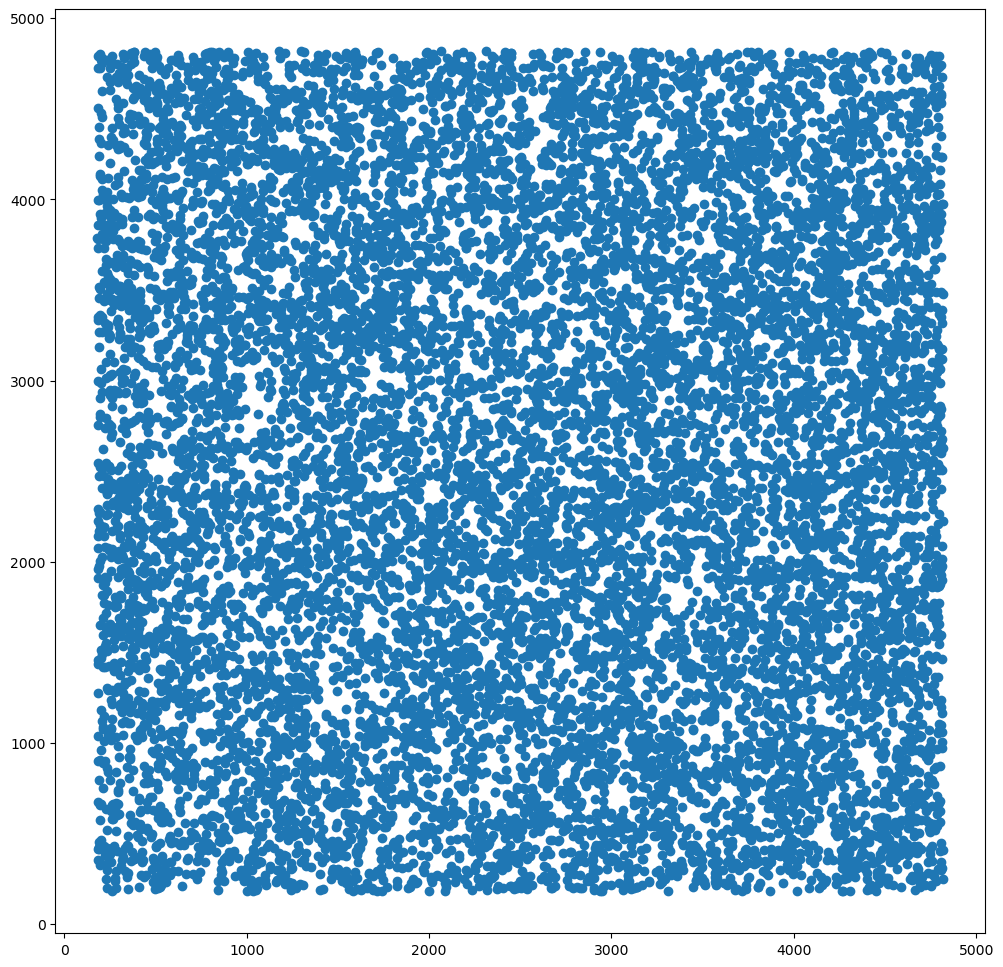

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)


ax.scatter(mock_catalog["X"], mock_catalog["Y"])

In [10]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_' + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_g
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_r
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_i
starting xshear calculations in 100 processes


In [11]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_g.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_r.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_i.fits


0.9390860199928284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


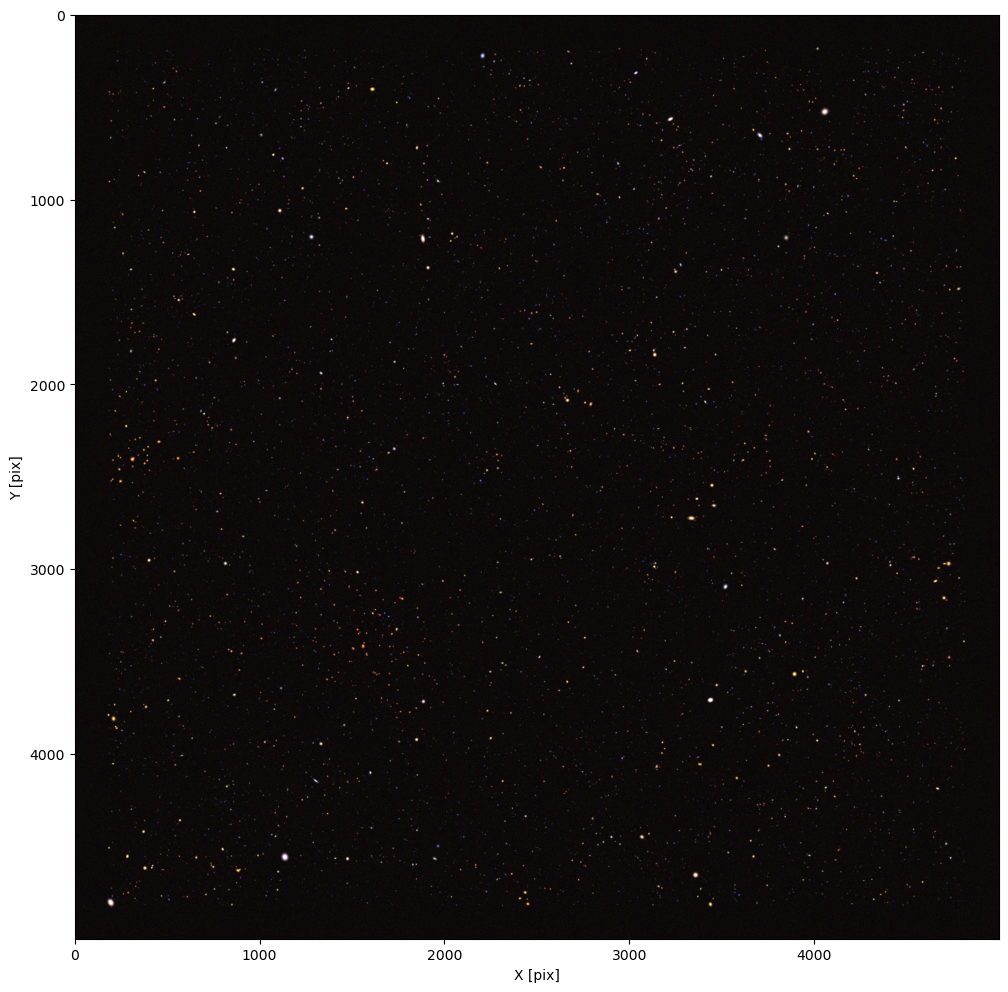

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp.png", bbox_inches='tight')

In [13]:
ihmaxes = np.argsort(table["halo_mass"])[::-1]

In [14]:
masses = table["halo_mass"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
ras = table["ra"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
decs = table["dec"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
xh, yh = radec2xy(ras, decs, sky_center=(ra_cen, dec_cen))

In [15]:
marker_sizes = (np.log10(masses).values - 12.6) ** 4 * 30

0.9390860199928284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


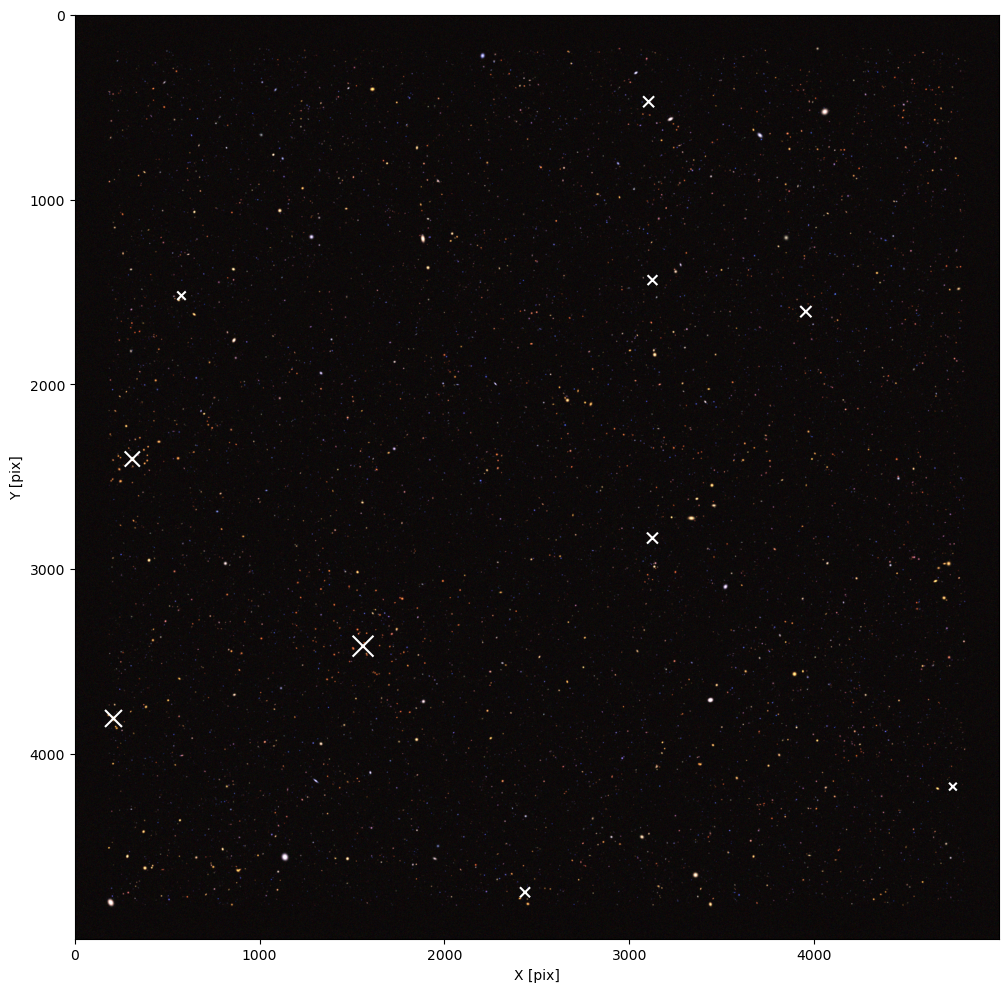

In [16]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')
ax.scatter(xh[::-1], yh[::-1], s=marker_sizes[::-1], color="white", marker="x")

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp_halos_in_FOV.png", bbox_inches='tight')